# Data Discovery

In [67]:
import numpy as np
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from collections import OrderedDict
import numpy as np
import fasttext
import re

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',5)

#### For this model I'll be preparing the data so that I can get get a representation of categorical variables using an embedding space from a language model.  These representations will then be used in place of the categorical variable its self and then fed through a simple feed forward network to be used as a variable to predict AirBnB prices.

In [68]:
#  Load data tables, making sure that listing_id is the same data
#  type across all three tables

cal = pd.read_csv('boston/calendar.csv', dtype={'listing_id':str})

listings = pd.read_csv('boston/listings.csv',dtype={'id':str, 'host_id': str, 'availability_30':np.int32, 
                                             'availability_60':np.int32, 'availability_90':np.int32, 
                                             'availability_365':np.int32}, parse_dates=True)

reviews = pd.read_csv('boston/reviews.csv', dtype={'listing_id':str}, parse_dates=True)

In [69]:
listings

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",NaN,"The bus stop is 2 blocks away, and frequent. B...","You will have access to 2 bedrooms, a living r...",NaN,Clean up and treat the home the way you'd like...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,31303940,https://www.airbnb.com/users/show/31303940,Virginia,2015-04-15,"Boston, Massachusetts, United States",We are country and city connecting in our deck...,NaN,NaN,NaN,f,https://a2.muscache.com/im/pictures/5936fef0-b...,https://a2.muscache.com/im/pictures/5936fef0-b...,Roslindale,1,1,"['email', 'phone', 'facebook', 'reviews']",t,f,"Birch Street, Boston, MA 02131, United States",Roslindale,Roslindale,NaN,Boston,MA,02131,Boston,"Boston, MA",US,United States,42.282619,-71.133068,t,House,Entire home/apt,4,1.5,2.0,3.0,Real Bed,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",NaN,$250.00,NaN,NaN,NaN,$35.00,1,$0.00,2,1125,2 weeks ago,NaN,0,0,0,0,2016-09-06,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...","If you don't have a US cell phone, you can tex...",Plenty of safe street parking. Bus stops a few...,Apt has one more bedroom (which I use) and lar...,"If I am at home, I am likely working in my hom...",Pet friendly but please confirm with me if the...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,2572247,https://www.airbnb.com/users/show/2572247,Andrea,2012-06-07,"Boston, Massachusetts, United States",I live in Boston and I like to travel and have...,within an hour,100%,100%,f,https://a2.muscache.com/im/users/2572247/profi...,https://a2.muscache.com/im/users/2572247/profi...,Roslindale,1,1,"['email', 'phone', 'facebook', 'linkedin', 'am...",t,t,"Pinehurst Street, Boston, MA 02131, United Sta


listings.csv


,col_name,nulls
0,id,0.0
1,listing_url,0.0
...,...,...
93,calculated_host_listings_count,0.0
94,reviews_per_month,21.1


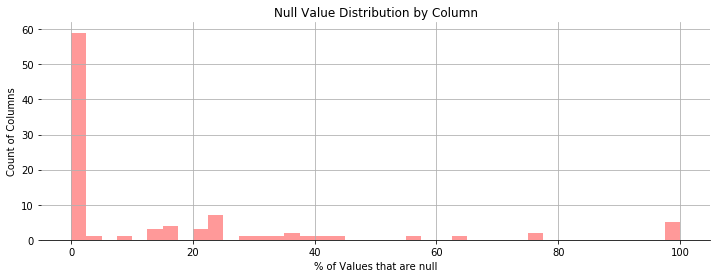

In [72]:
title = 'Null Value Distribution by Column'
y_label = 'Count of Columns'
x_label = '% of Values that are null'

def graph_nulls(df, table_title, title=title, y_label=y_label, x_label=x_label):
    '''graphs the number of null values for a given dataframe in the form of a histogram'''
    
    temp = list(zip(df.columns, round((df.isnull().sum() / df.shape[0])*100,1)))
    index=[i for i in range(len(temp))]
    df_temp=pd.DataFrame({'col_name':0, 'nulls':0}, index=index)
    for num, (col, val) in enumerate(temp):
        df_temp.iloc[num,0]=col
        df_temp.iloc[num,1]=val
    
    fig, ax1 = plt.subplots(1, 1, figsize=(12, 4))
    df_temp.hist(bins=40, color='red', alpha=0.4, ax=ax1)
    sns.despine(top=True, right=True, left=True)
    ax1.set_title(title)
    ax1.set_ylabel(y_label)
    ax1.set_xlabel(x_label)
    print(table_title)
    return df_temp

graph_nulls(listings, '\nlistings.csv')


reviews.csv


,col_name,nulls
0,listing_id,0.0
1,id,0.0
...,...,...
4,reviewer_name,0.0
5,comments,0.1


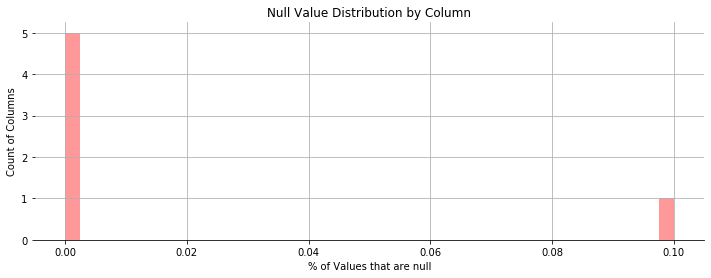

In [73]:
graph_nulls(reviews, '\nreviews.csv')


cal.csv


,col_name,nulls
0,listing_id,0.0
1,date,0.0
2,available,0.0
3,price,50.9


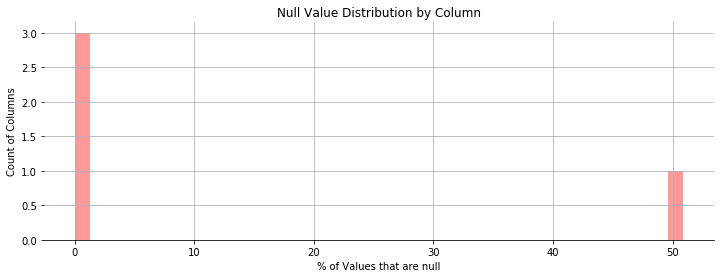

In [74]:
graph_nulls(cal, '\ncal.csv')

In [66]:
#  filter out null values from cal since these will be used as the dependent variable
#  also make sure that all 'available' values are equal to 't'

cal = cal[(cal['price'].notnull()==True) & (cal['available']=='t')]
cal

,listing_id,date,available,price
365,3075044,2017-08-22,t,$65.00
366,3075044,2017-08-21,t,$65.00
...,...,...,...,...
1308878,14504422,2016-09-17,t,$62.00
1308879,14504422,2016-09-16,t,$62.00


In [7]:
# Replacing my N/A with a number that otherwise does not show up in the dataset
# I'm doing this because I want to use all my data/since neural networks can deal with it

datasets=[cal, reviews]
for data in datasets:
    data['date'] = data['date'].fillna(0)
    data=data.replace('nan', np.nan)
    data=data.fillna(9999)
    
listings=listings.replace('nan', np.nan)
listings=listings.fillna(9999)

In [8]:
# Reformatting price from string to integer to compare prices in the cal and 
# # listings tables to see if they are the same

cal['price'] = cal['price'].apply(lambda x: str(x).replace('$',''))
cal['price'] = cal['price'].apply(lambda x: np.int64(round(np.float32(x.replace(',','')),0)))

for col in ['price','security_deposit','cleaning_fee', 'extra_people']:
    listings[col] = listings[col].apply(lambda x: str(x).replace('$',''))
    listings[col] = listings[col].apply(lambda x: np.int64(round(np.float32(x.replace(',','')),0)))

Text(0.5, 0, 'Price ($)')

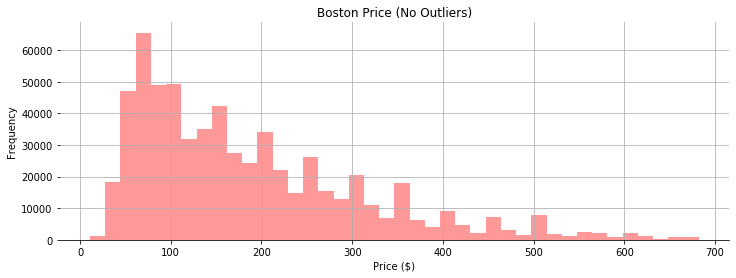

In [9]:
# Filter out prices > 99.99% expected based on price stdev
# just so we can see distribution of prices better

threshold = 3.79 * cal['price'].std()
prices = cal[cal['price']<threshold]
             
fig, ax1 = plt.subplots(1, 1, figsize=(12, 4))
prices.hist(bins=40, color='red', alpha=0.4, ax=ax1)
sns.despine(top=True, right=True, left=True)

ax1.set_title('Boston Price (No Outliers)')
ax1.set_ylabel('Frequency')
ax1.set_xlabel('Price ($)')

Text(0.5, 0, 'log( Price )')

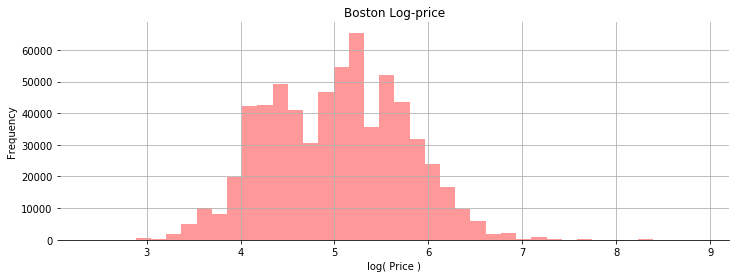

In [10]:
# View Price Distribution as Log Price

prices = cal['price'].map(lambda x: np.log(x))

# Visualize again...
fig, ax1 = plt.subplots(1, 1, figsize=(12, 4))
prices.hist(bins=40, color='red', alpha=0.4, ax=ax1)
sns.despine(top=True, right=True, left=True)

ax1.set_title('Boston Log-price')
ax1.set_ylabel('Frequency')
ax1.set_xlabel('log( Price )')



# Load Vectors from FastText

You can install the fastText module by following the instructions here: 

https://github.com/facebookresearch/fastText

And download the language model from here:

https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M-subword.zip

# Why am I doing this?
I want to test the effectiveness of using embeddings to directly substitute categorical variables when conducting time series analyses.  To do this I will test direct substitution of categoricals with the sum of the vector representing the variable.  For example, if the FastText representation is [1,2,3] then I would use 6 to represent that variable prioring to normalizing across the entire feature.I will then consider all subsequent analysis as consisting only of continuous variables.  

The results from this will then be tested vs using different embedding spaces to represent the different features. Ideally the results should be very similar with both methods.

In [11]:
import fasttext

In [12]:
model = fasttext.load_model("crawl-300d-2M-subword.bin")

In [13]:
from collections import OrderedDict
import numpy as np

# I'm getting FastText representations of each feature in a df using this function

def get_vecs(df, model):
    '''returns an ordereddict of fasttext embeddings for each col of a given dataframe'''
    vecs = OrderedDict()
    for col in list(df.columns):
        counter = 0
        cols = OrderedDict()
        for word in df[col].tolist():
            cols[counter] = np.array(model.get_word_vector(str(word)))
            counter += 1
        vecs[col] = cols

    return vecs

In [14]:
vecs = get_vecs(listings, model)

In [15]:
cols = OrderedDict()
for rows, ids in enumerate(listings['id'].tolist()):
    cols[rows] = ids
vecs['ids_orig'] = cols

In [16]:
# In-case you want to save the dictionary

torch.save(vecs, 'vecs.pth')
# vecs = torch.load('vecs.pth')

In [17]:
vector_cols = pd.DataFrame(vecs)

In [18]:
# For the sake of simplicity I'm just getting vectors of every feature here.  
# Ultimatley I'll just replace categorical variables.

vectors=['id',
 'listing_url',
 'scrape_id',
 'last_scraped',
 'name',
 'summary',
 'space',
 'description',
 'experiences_offered',
 'neighborhood_overview',
 'notes',
 'transit',
 'access',
 'interaction',
 'house_rules',
 'thumbnail_url',
 'medium_url',
 'picture_url',
 'xl_picture_url',
 'host_id',
 'host_url',
 'host_name',
 'host_since',
 'host_location',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_thumbnail_url',
 'host_picture_url',
 'host_neighbourhood',
 'host_listings_count',
 'host_total_listings_count',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified',
 'street',
 'neighbourhood',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'city',
 'state',
 'zipcode',
 'market',
 'smart_location',
 'country_code',
 'country',
 'latitude',
 'longitude',
 'is_location_exact',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'bed_type',
 'amenities',
 'square_feet',
 'price',
 'weekly_price',
 'monthly_price',
 'security_deposit',
 'cleaning_fee',
 'guests_included',
 'extra_people',
 'minimum_nights',
 'maximum_nights',
 'calendar_updated',
 'has_availability',
 'availability_30',
 'availability_60',
 'availability_90',
 'availability_365',
 'calendar_last_scraped',
 'number_of_reviews',
 'first_review',
 'last_review',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'requires_license',
 'license',
 'jurisdiction_names',
 'instant_bookable',
 'cancellation_policy',
 'require_guest_profile_picture',
 'require_guest_phone_verification',
 'calculated_host_listings_count',
 'reviews_per_month']

In [19]:
# Here I am replacing categorical variables with the mean 
# of their respective FastText representations

for x in vectors:
    vector_cols[x]=vector_cols[x].apply(lambda x: np.sum(x))

In [20]:
vector_cols

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,ids_orig
0,-0.046838,0.034783,-0.626554,-0.469541,-0.143649,-0.105731,-0.063274,-0.094853,-0.352809,-0.104129,-0.185235,-0.088644,-0.165903,-0.185235,-0.220075,-0.081964,-0.059178,-0.081981,-0.062567,-0.247363,0.007976,-0.660561,-0.133261,-0.122917,-0.031289,-0.185235,-0.185235,-0.185235,0.041419,-0.031137,-0.025658,-0.222718,-2.810879,-2.810879,0.033346,-4.22991,0.041419,-0.167184,-0.222718,-0.222718,-1.101435,-0.325495,-1.935437,-0.954856,-0.325495,-0.268408,-2.972327,-0.130206,-0.661377,-0.466070,-4.22991,-0.946798,-0.263949,-0.491343,-0.762002,-0.361605,-0.052080,-0.152091,-0.000610,-1.101435,0.330488,-0.185235,-0.185235,-0.185235,-0.632270,-2.810879,-0.968029,-0.925067,0.713693,0.362114,-1.101435,-0.968029,-0.968029,-0.968029,-0.968029,-0.430144,-0.968029,-0.185235,-0.185235,-1.101435,-1.101435,-1.101435,-1.101435,-1.101435,-1.101435,-1.101435,0.041419,-1.101435,-1.101435,0.041419,-0.024288,0.041419,0.041419,-2.810879,-1.101435,12147973
1,-0.826929,0.125584,-0.626554,-0.469541,-0.033042,-0.014554,-0.028076,-0.080831,-0.352809,-0.119111,-0.050325,-0.085042,-0.107384,-0.067319,-0.110992,0.093293,0.116712,0.093274,0.110827,-0.555106,-0.035174,0.584588,-0.420699,-0.122917,-0.126840,0.140238,-1.071674,-1.071674,0.041419,-0.023288,-0.018037,-0.222718,-2.810879,-2.810879,0.074280,-4.22991,-4.229910,-0.106870,-0.222718,-0.222718,-1.101435,-0.325495,-1.935437,-0.954856,-0.325495,-0.268408,-2.972327,-0.130206,-0.523037,-0.365482,-4.22991,0.212986,-0.215052,-0.925067,-0.575764,-0.575764,-0.575764,-0.152091,-0.038380,-1.101435,-0.187015,-0.131141,-0.185235,-0.043031,-0.126274,-0.968029,-0.968029,-0.925067,-0.684165,-0.063365,-1.101435,-0.846245,-1.096296,0.062748,-0.384037,-0.430144,-0.403460,-0.492077,-0.063742,-2.207720,-0.633502,-0.840528,-0.633502,-0.633502,-0.840528,-0.840528,0.041419,-1.101435,-1.101435,-4.229910,-0.024288,0.041419,0.041419,-2.810879,-1.200118,3075044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3583,-0.691371,-0.083573,-0.626554,-0.469541,-0.163814,-0.006271,-0.185235,-0.006271,-0.352809,-0.185235,-0.185235,-0.185235,-0.185235,-0.185235,-0.185235,-0.033701,-0.011435,-0.033719,-0.015331,-0.213965,0.048318,1.018579,-0.430154,-0.101082,-0.027533,0.140238,-1.071674,0.007236,0.041419,-0.

# Lets also include some information contained in the sentiment of user reviews
#### Using a neural network I previously trained using IMBD sentiment I will be adding columns with the number of positive and negative reviews for each listing ID

For information on how to train an IMBD based sentiment analysis look here:

https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson3-imdb.ipynb

For the sake of staying focused on the topic at hand for this article I am just loading in a csv with listing_ids and positive/negative sentiment counts in different columns where Sentiment was analyzed using inference from the IMBD model.  There's is probably some finetuning I could do here but for the sake of demonstrating the use of embeddings in time series analysis I'm not worrying about that for this analysis.

In [21]:
reviews = pd.read_csv('reviews_with_cats.csv', dtype={'listing_id': str})
reviews

,listing_id,id,reviewer_id,category_neg,category_pos
0,3353,851930481,503715150,7.0,27.0
1,5506,388718409,273512856,2.0,34.0
...,...,...,...,...,...
2827,14843050,198711889,100629012,0.0,2.0
2828,14843783,298890717,157835817,0.0,3.0


In [22]:
#  Merge the listings table with the reviews table
#  here I am using the vectors table instead of listings since these
#  values have already been replaced by mean embeddings for text data

vector_cols['ids_orig']=vector_cols['ids_orig'].astype(str)
listings_merge1 = cal.merge(vector_cols, left_on='listing_id', right_on='ids_orig', how='left', copy=False)

df2 = listings_merge1.merge(reviews, left_on='ids_orig', right_on='listing_id')
df2=df2.drop(['listing_id_x', 'id_x', 'listing_id_y', 'id_y'], axis=1)
df2

,date,available,price_x,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price_y,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,ids_orig,reviewer_id,category_neg,category_pos
0,2017-08-22,t,65,0.125584,-0.626554,-0.469541,-0.033042,-0.014554,-0.028076,-0.080831,-0.352809,-0.119111,-0.050325,-0.085042,-0.107384,-0.067319,-0.110992,0.093293,0.116712,0.093274,0.110827,-0.555106,-0.035174,0.584588,-0.420699,-0.122917,-0.126840,0.140238,-1.071674,-1.071674,0.041419,-0.023288,-0.018037,-0.222718,-2.810879,-2.810879,0.07428,-4.22991,-4.22991,-0.106870,-0.222718,-0.222718,-1.101435,-0.325495,-1.935437,-0.954856,-0.325495,-0.268408,-2.972327,-0.130206,-0.523037,-0.365482,-4.22991,0.212986,-0.215052,-0.925067,-0.575764,-0.575764,-0.575764,-0.152091,-0.038380,-1.101435,-0.187015,-0.131141,-0.185235,-0.043031,-0.126274,-0.968029,-0.968029,-0.925067,-0.684165,-0.063365,-1.101435,-0.846245,-1.096296,0.062748,-0.384037,-0.430144,-0.403460,-0.492077,-0.063742,-2.207720,-0.633502,-0.840528,-0.633502,-0.633502,-0.840528,-0.840528,0.041419,-1.101435,-1.101435,-4.229910,-0.024288,0.041419,0.041419,-2.810879,-1.200118,3075044,931576529,2.0,34.0
1,2017-08-21,t,65,0.125584,-0.626554,-0.469541,-0.033042,-0.014554,-0.028076,-0.080831,-0.352809,-0.119111,-0.050325,-0.085042,-0.107384,-0.067319,-0.110992,0.093293,0.116712,0.093274,0.110827,-0.555106,-0.035174,0.584588,-0.420699,-0.122917,-0.126840,0.140238,-1.071674,-1.071674,0.041419,-0.023288,-0.018037,-0.222718,-2.810879,-2.810879,0.07428,-4.22991,-4.22991,-0.106870,-0.222718,-0.222718,-1.101435,-0.325495,-1.935437,-0.954856,-0.325495,-0.268408,-2.972327,-0.130206,-0.523037,-0.365482,-4.22991,0.212986,-0.215052,-0.925067,-0.575764,-0.575764,-0.575764,-0.152091,-0.038380,-1.101435,-0.187015,-0.131141,-0.185235,-0.043031,-0.126274,-0.968029,-0.968029,-0.925067,-0.684165,-0.063365,-1.101435,-0.846245,-1.096296,0.062748,-0.384037,-0.430144,-0.403460,-0.492077,-0.063742,-2.207720,-0.633502,-0.840528,-0.633502,-0.633502,-0.840528,-0.840528,0.041419,-1.101435,-1.101435,-4.229910,-0.024288,0.041419,0.041419,-2.810879,-1.200118,3075044,931576529,2.0,34.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527154,2016-09-09,t,59,-0.083573,-0.626554,-0.469541,-0.163814,-0.006271,-0.185235,-0.006271,-0.352809,-0.185235,-0.185235,-0.185235,-0.185235,-0.185235,-0.185235,-0.0337

In [23]:
# Sorting by time and listing ID so that validation
# set can be defined on future events relative to train set

df2 = df2.sort_values(by=['date', 'ids_orig'], ascending=[True, False])

In [24]:
from fastai.tabular import *

In [25]:
# Here I am defining the columns I want to use
# to try to predict prices

continuous = ['name',
 'summary',
 'space',
 'description',
 'experiences_offered',
 'neighborhood_overview',
 'notes',
 'transit',
 'access',
 'interaction',
 'house_rules',
              
#  Don't think urls will give me anything relevant so taking 
#  them out
              
#  'thumbnail_url',
#  'medium_url',
#  'picture_url',
#  'xl_picture_url',
#  'host_id',
#  'host_url',
              
 'host_name',
 'host_since',
 'host_location',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
#  'host_thumbnail_url',
#  'host_picture_url',
 'host_neighbourhood',
 'host_listings_count',
 'host_total_listings_count',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified',
 'street',
 'neighbourhood',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'city',
 'state',
 'zipcode',
 'market',
 'smart_location',
 'country_code',
 'country',
 'latitude',
 'longitude',
 'is_location_exact',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'bed_type',
 'amenities',
 'square_feet',
              
#  Need to take these out, otherwise it's cheating! :)
#  Cleaning fee and security deposit wouldn't be known when trying to figure out a rental price so I'm excluding these
              
#  'price_y',
#  'weekly_price',
#  'monthly_price',
#  'security_deposit',
#  'cleaning_fee',
              
 'guests_included',
 'extra_people',
 'minimum_nights',
 'maximum_nights',
 'calendar_updated',
 'has_availability',
 'availability_30',
 'availability_60',
 'availability_90',
 'availability_365',
 'calendar_last_scraped',
 'number_of_reviews',
 'first_review',
 'last_review',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'requires_license',
 'license',
 'jurisdiction_names',
 'instant_bookable',
 'cancellation_policy',
 'require_guest_profile_picture',
 'require_guest_phone_verification',
 'calculated_host_listings_count',
 'reviews_per_month',
 'Year',
 'Month',
 'Week',
 'Day',
 'Dayofweek',
 'Dayofyear',
 'Is_month_end',
 'Is_month_start',
 'Is_quarter_end',
 'Is_quarter_start',
 'Is_year_end',
 'Is_year_start',
 'Elapsed', 
 'category_neg', 
 'category_pos']

In [26]:
from fastai.tabular import *

# using fastai tabular adds some convieniant functions to allow the model to detect seasonality
# add_datepart parses dates into lots of variables helpful for time series data

add_datepart(df2, 'date')
df2.iloc[:,-13:]

,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
76477,2016,9,36,6,1,250,False,False,False,False,False,False,1473120000
87692,2016,9,36,6,1,250,False,False,False,False,False,False,1473120000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
510979,2017,9,36,5,1,248,False,False,False,False,False,False,1504569600
42989,2017,9,36,5,1,248,False,False,False,False,False,False,1504569600


# RangerVA optimizer
https://github.com/lessw2020/Ranger-Deep-Learning-Optimizer

https://medium.com/@lessw/new-deep-learning-optimizer-ranger-synergistic-combination-of-radam-lookahead-for-the-best-of-2dc83f79a48d

Using the code from lessw2020 I'm adding a state-of-the-art optimizer just to make sure I'm getting all I can out of the data in terms of performance.  Feel free to skip this as it's not entirely relevant.

In [95]:
import math
import torch
from torch.optim.optimizer import Optimizer, required
import itertools as it


class RangerVA(Optimizer):
    '''returns an optimizer as described in https://github.com/lessw2020/Ranger-Deep-Learning-Optimizer'''

    def __init__(self, params, lr=1e-3, alpha=0.5, k=6, n_sma_threshhold=5, betas=(.95,0.999), 
                 eps=1e-5, weight_decay=0, amsgrad=True, transformer='softplus', smooth=50,
                 grad_transformer='square'):
        #parameter checks
        if not 0.0 <= alpha <= 1.0:
            raise ValueError(f'Invalid slow update rate: {alpha}')
        if not 1 <= k:
            raise ValueError(f'Invalid lookahead steps: {k}')
        if not lr > 0:
            raise ValueError(f'Invalid Learning Rate: {lr}')
        if not eps > 0:
            raise ValueError(f'Invalid eps: {eps}')

        #parameter comments:
        # beta1 (momentum) of .95 seems to work better than .90...
        #N_sma_threshold of 5 seems better in testing than 4.
        #In both cases, worth testing on your dataset (.90 vs .95, 4 vs 5) to make sure which works best for you.

        #prep defaults and init torch.optim base
        defaults = dict(lr=lr, alpha=alpha, k=k, step_counter=0, betas=betas, 
                        n_sma_threshhold=n_sma_threshhold, eps=eps, weight_decay=weight_decay,
                        smooth=smooth, transformer=transformer, grad_transformer=grad_transformer,
                       amsgrad=amsgrad)
        super().__init__(params,defaults)

        #adjustable threshold
        self.n_sma_threshhold = n_sma_threshhold   

        #look ahead params
        self.alpha = alpha
        self.k = k 

        #radam buffer for state
        self.radam_buffer = [[None,None,None] for ind in range(10)]

    def __setstate__(self, state):
        print("set state called")
        super(Ranger, self).__setstate__(state)


    def step(self, closure=None):
        '''returns loss after after performing an optimization step'''
        loss = None

        #Evaluate averages and grad, update param tensors
        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('Ranger optimizer does not support sparse gradients')
                
                amsgrad = group['amsgrad']
                smooth = group['smooth']
                grad_transformer = group['grad_transformer']

                p_data_fp32 = p.data.float()

                state = self.state[p]  #get state dict for this param

                if len(state) == 0:   #if first time to run...init dictionary with our desired entries
                    #if self.first_run_check==0:
                        #self.first_run_check=1
                        #print("Initializing slow buffer...should not see this at load from saved model!")
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                    if amsgrad:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(p.data)                    

                    #look ahead weight storage now in state dict 
                    state['slow_buffer'] = torch.empty_like(p.data)
                    state['slow_buffer'].copy_(p.data)

                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)
                                      
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']
                if amsgrad:
                        max_exp_avg_sq = state['max_exp_avg_sq']  
                                
                #compute variance mov avg
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                #compute mean moving avg
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                
            
                ##transformer
                if grad_transformer == 'square':
                    grad_tmp = grad**2
                elif grad_transformer == 'abs':
                    grad_tmp = grad.abs()

                exp_avg_sq.mul_(beta2).add_((1 - beta2)*grad_tmp)

                if amsgrad:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denomc = max_exp_avg_sq.clone()
                else:
                    denomc = exp_avg_sq.clone()

                if grad_transformer == 'square':
                    #pdb.set_trace()
                    denomc.sqrt_()                 
                
                state['step'] += 1

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
                     
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1                

                # ...let's use calibrated alr 
                if  group['transformer'] =='softplus':
                    sp = torch.nn.Softplus( smooth)
                    denomf = sp( denomc)
                    p_data_fp32.addcdiv_(-step_size, exp_avg, denomf )  
                    
                else:
                    
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size * group['lr'], exp_avg, denom)
                
                p.data.copy_(p_data_fp32)

                #integrated look ahead...
                #we do it at the param level instead of group level
                if state['step'] % group['k'] == 0:
                    slow_p = state['slow_buffer'] #get access to slow param tensor
                    slow_p.add_(self.alpha, p.data - slow_p)  #(fast weights - slow weights) * alpha
                    p.data.copy_(slow_p)  #copy interpolated weights to RAdam param tensor

        return loss

# Creating the FeedForward Neural Net
#### I'm now taking the "encoded" categoricals and the continuous variables and putting them through fastai's tabular UI
#### Below I'm creating a datachunk which is basically a tuple of independent and dependent variables plus a dataloader

In [117]:
# Defining variables to be used in the model
path = Path('./Documents/airbnb')
cont_names = continuous
dep_vars = ['price_x']

In [118]:
index = int(round(df2.shape[0]-df2.shape[0]*0.15,0))
rows = int(round(df2.shape[0]-df2.shape[0]*0.05,0))

test = df2.iloc[rows:]
max_log_y = np.log(df2.price_x.max())*1.1
y_range = torch.Tensor([0,max_log_y])

In [119]:
from fastai.tabular import *
# I'm using fastAI to skip some of the preprocessing
# This sets up both datasets and dataloaders in pytorch across train, validation, and test sets

procs = [FillMissing, Categorify, Normalize]
data = (TabularList.from_df(df2, path=path, cat_names=['ids_orig'], cont_names=continuous, procs=procs)
                           .split_by_idx(list(range(index,rows)))
                           .label_from_df(cols='price_x', label_cls=FloatList, log=True)
                           .add_test(TabularList.from_df(test,path=path,cat_names=['ids_orig'],cont_names=continuous, procs=procs))
                           .databunch(bs=256))


In [139]:
from fastai.distributed import *
import torch.nn as nn

drop=0.05
# Define Optimizer to use RangerVA

optar = partial(RangerVA)

learn = tabular_learner(data, 
                        layers=[2048,1024,512,256,128,128,128], 
                        metrics=[exp_rmspe], 
                        emb_drop=drop, 
                        ps=[drop],
                        y_range=y_range,
                        opt_func=optar,
                        wd=0.01)

In [140]:
from fastai.callbacks import *

In [141]:
# Initializing parameters with kaiming normal as results are much better if doing this

def init_model(m):
    '''function to initiate parameters in a given model using kaiming normal initiation'''
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        if hasattr(m, 'weight') and m.weight is not None: nn.init.kaiming_normal_(m.weight, 1e-2, mode='fan_out')
        if hasattr(m, 'bias') and m.bias is not None:     nn.init.constant_(m.bias, 0.)
    elif classname.find('LayerNorm') != -1:
        if hasattr(m, 'weight') and m.weight is not None: nn.init.normal_(m.weight, 1., 0.02)
        if hasattr(m, 'bias') and m.bias is not None:     nn.init.constant_(m.bias, 0.)
    elif classname.find('Embedding') != -1:
        if hasattr(m, 'weight'): nn.init.kaiming_normal_(m.u, 1e-2, mode='fan_out')
        if hasattr(m, 'bias'):  nn.init.constant_(m.bias, 0.)
            
init_model(learn.model)

epoch,train_loss,valid_loss,exp_rmspe,time


set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.63E-05
Min loss divided by 10: 7.59E-08


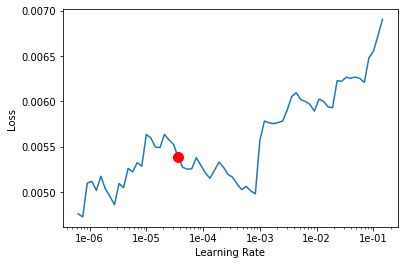

In [147]:
# Now I'm finding the optimal learning rate for one cycle training

learn.to_fp16()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [145]:
from fastai.callbacks import *
# I'm creating callbacks which is a fastai feature that calls certain
# functions during different points during model training

early = EarlyStoppingCallback(learn, patience=10)
lr_lower = ReduceLROnPlateauCallback(learn, patience=1)
saver = SaveModelCallback(learn, name='best')
graph = ShowGraph(learn)


epoch,train_loss,valid_loss,exp_rmspe,time
0,0.028646,0.028049,0.169335,00:30
1,0.020200,0.012056,0.115241,00:32
2,0.017560,0.011690,0.108872,00:33
3,0.015445,0.010978,0.109255,00:33
4,0.015921,0.010539,0.103828,00:33
5,0.014409,0.009973,0.095279,00:33
6,0.014688,0.011362,0.102459,00:34
7,0.013491,0.011044,0.099805,00:35
8,0.010613,0.008080,0.089812,00:35
9,0.009946,0.008321,0.094144,00:35


Better model found at epoch 0 with valid_loss value: 0.02804899588227272.


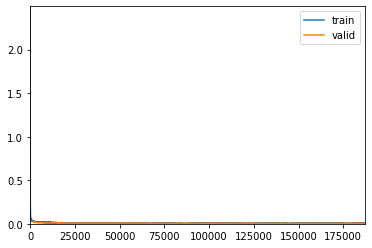

Better model found at epoch 1 with valid_loss value: 0.012055614963173866.
Better model found at epoch 2 with valid_loss value: 0.011689608916640282.
Better model found at epoch 3 with valid_loss value: 0.010978491976857185.
Better model found at epoch 4 with valid_loss value: 0.010538545437157154.
Better model found at epoch 5 with valid_loss value: 0.009972932748496532.
Epoch 7: reducing lr to 0.0024000000000000002
Better model found at epoch 8 with valid_loss value: 0.00807954277843237.
Epoch 10: reducing lr to 0.00048000000000000007
Better model found at epoch 11 with valid_loss value: 0.007900793105363846.
Better model found at epoch 13 with valid_loss value: 0.0077967834658920765.
Better model found at epoch 14 with valid_loss value: 0.007550626061856747.
Better model found at epoch 20 with valid_loss value: 0.007432335987687111.
Better model found at epoch 29 with valid_loss value: 0.007380071561783552.
Better model found at epoch 33 with valid_loss value: 0.007189745549112558.


In [146]:
learn.fit(101, 1.2e-2, callbacks=[lr_lower, saver, graph])

In [87]:
learn.save('best-airbnb')

# The same model was run here without replacing categorical variables by their FastText representation

When FastAI creates a model here it uses cardinality to determine embedding size for each categorical where:

emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]  - c is equal to number of unique values for each feature

See this workbook for an example:
https://github.com/fastai/fastai/blob/master/courses/dl1/lesson3-rossman.ipynb

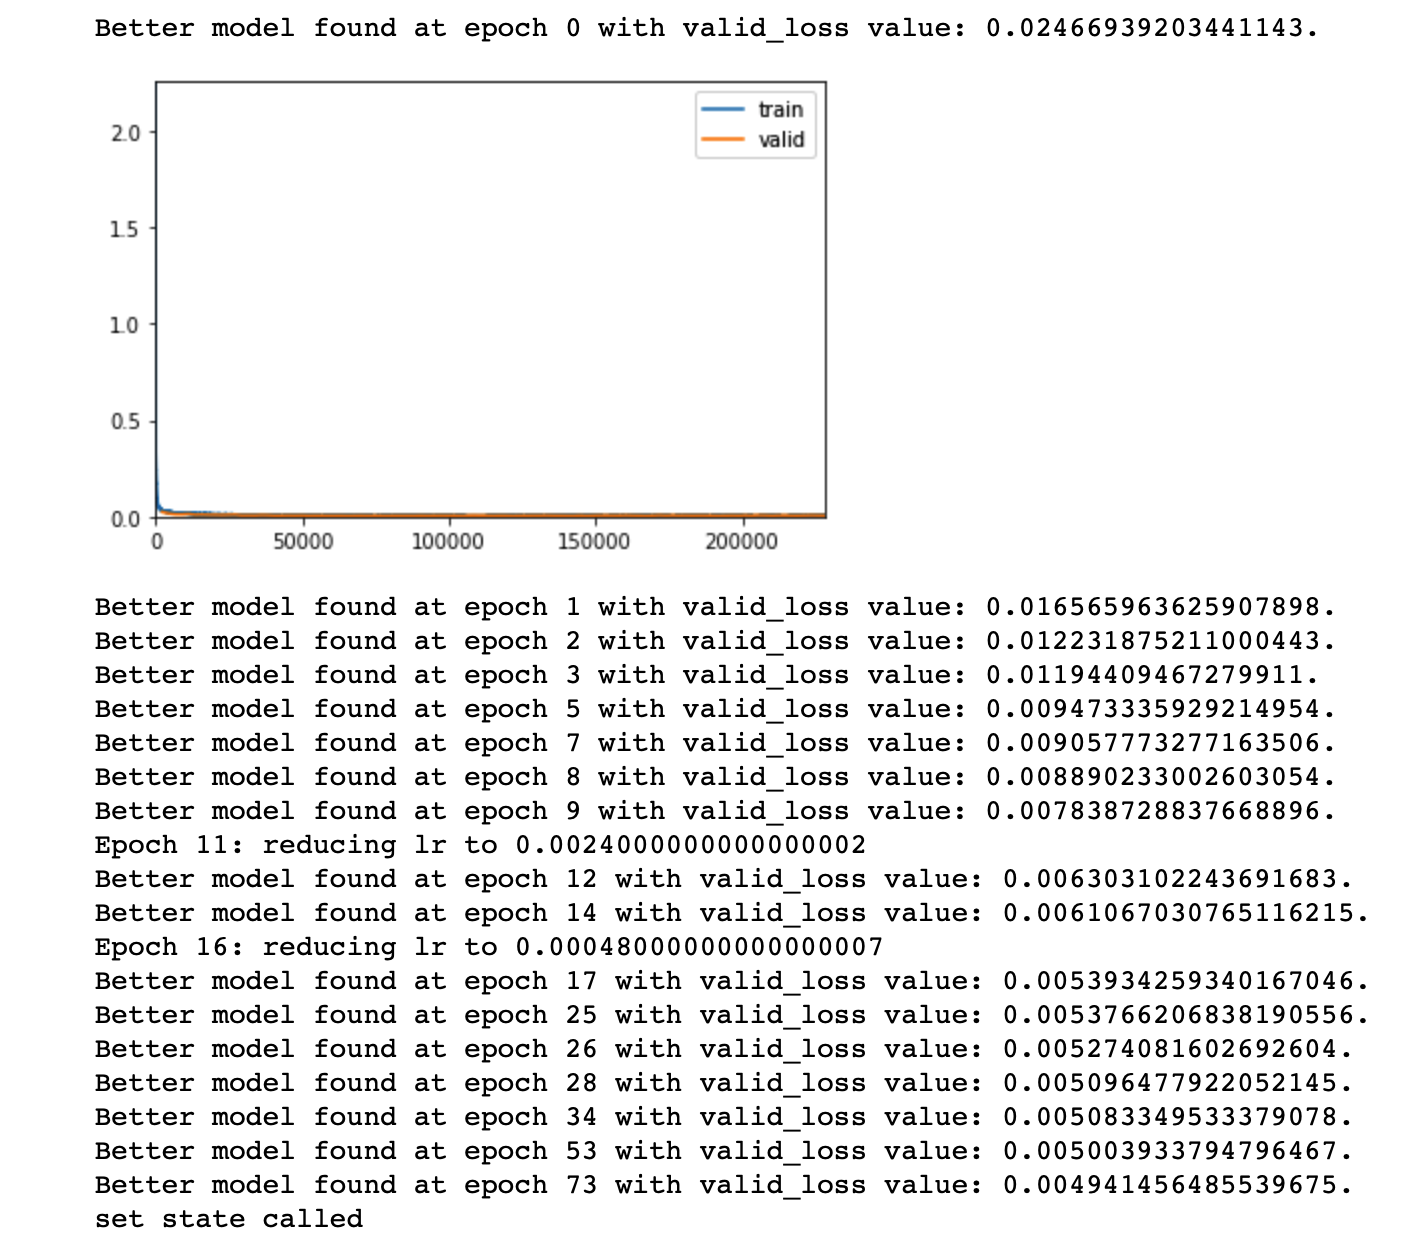

# Results

Overall, results are very similar and come up with a RMSE within 0.0005 of each other where the model that did not leverage FastText representations only showed a slight performance advantage.

# Why is this so cool?

It shows (at a high level) that language models are useful for representing categorical variables since language models allow us to differentiate, within each feature, between variables that are similar to one another and those that are inherently different.  

Further work would need to be done, but I suspect that using full representations hat the performance of the model would only improve and would surpass that of the baseline model (instead of just taking the sum of all vector elements like I have here).  Better model architectures (such as transformers) would improve performance on time series analysis even further.  

The main point here is that language models serve a role in time series models/perediction that have not yet been fully explored by academics.